In [13]:
%load_ext autoreload
%autoreload 2
# imports
import logging
import sys, os
import time
from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator, PoseEstimator
from tf_pose.networks import get_graph_path, model_wh
from tf_pose.common import CocoPart, CocoPairsRender, CocoPairsNetwork
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import asyncio
import datetime
import random
import io

import http.server
import socketserver
import threading
from IPython.display import IFrame
import base64
from PIL import Image
from io import BytesIO
import re
from utils import  get_humans_as_lines, is_same_image,print_image_Stats , compare_poses
from plot_utils import plot_pose, plot_human_lines,gen_plot
from loss_functions import multi_stage_loss, final_stage_heat_loss
import tensorflow as tf
import math
import copy
from tqdm import tqdm
import datetime
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))

from tf_pose.tensblur.smoother import Smoother


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# params 432, 368
w, h = 432, 368
image_path_source = '../data/images/lea_source.jpg'
image_path_target = '../data/images/lea_target_far.jpg'
model = 'cmu'
log_dir = '../logs/'
resize_out_ratio = 2.0
image_source = common.read_imgfile(image_path_source, w, h)
image_target = common.read_imgfile(image_path_target, w, h)

summary_writer = tf.summary.FileWriter(log_dir + "peakMove/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [4]:
e_source = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
e_target = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
upsample_size = [int(e_target.target_size[1] / 8 * resize_out_ratio), int(e_target.target_size[0] / 8 * resize_out_ratio)]

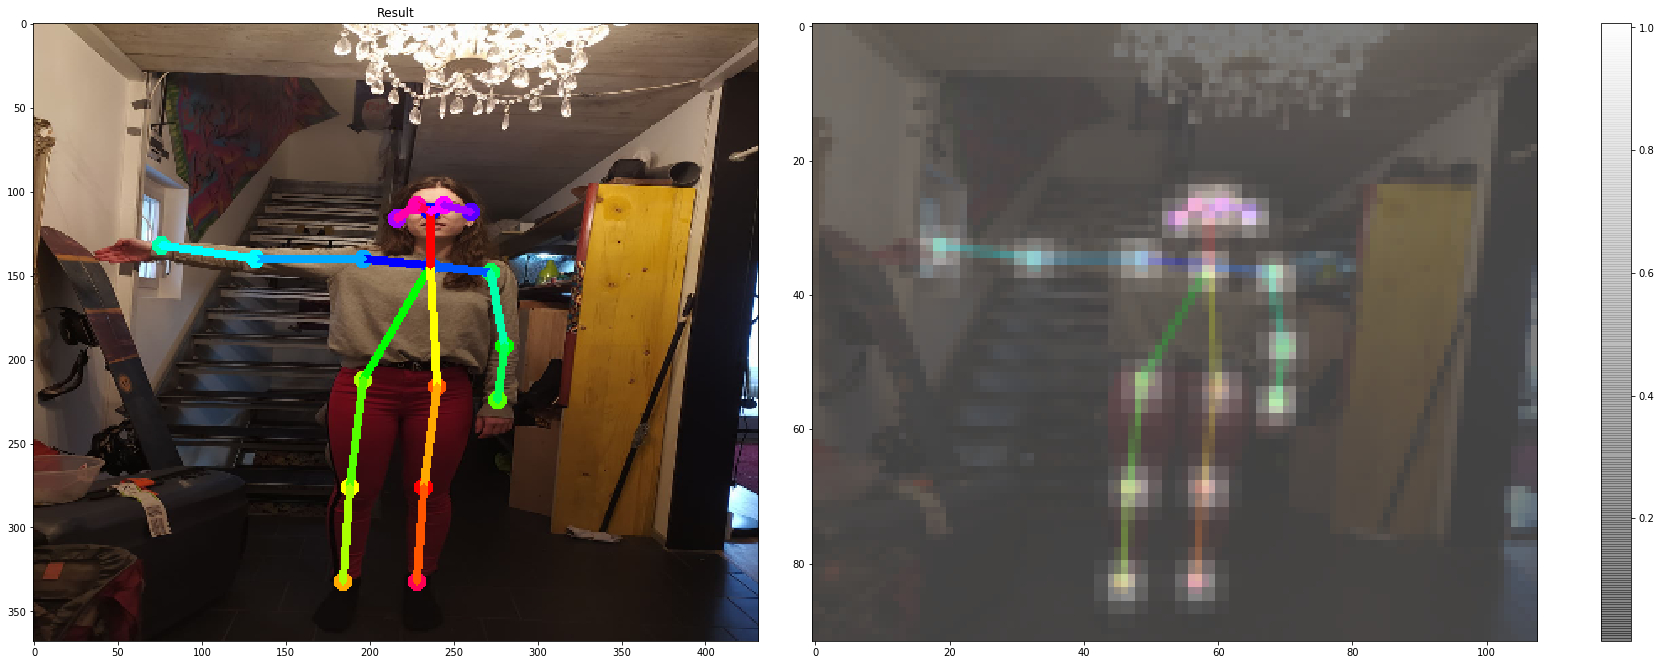

In [5]:
human_source = e_source.inference(image_source, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_source, human_source, e_source.heatMat)

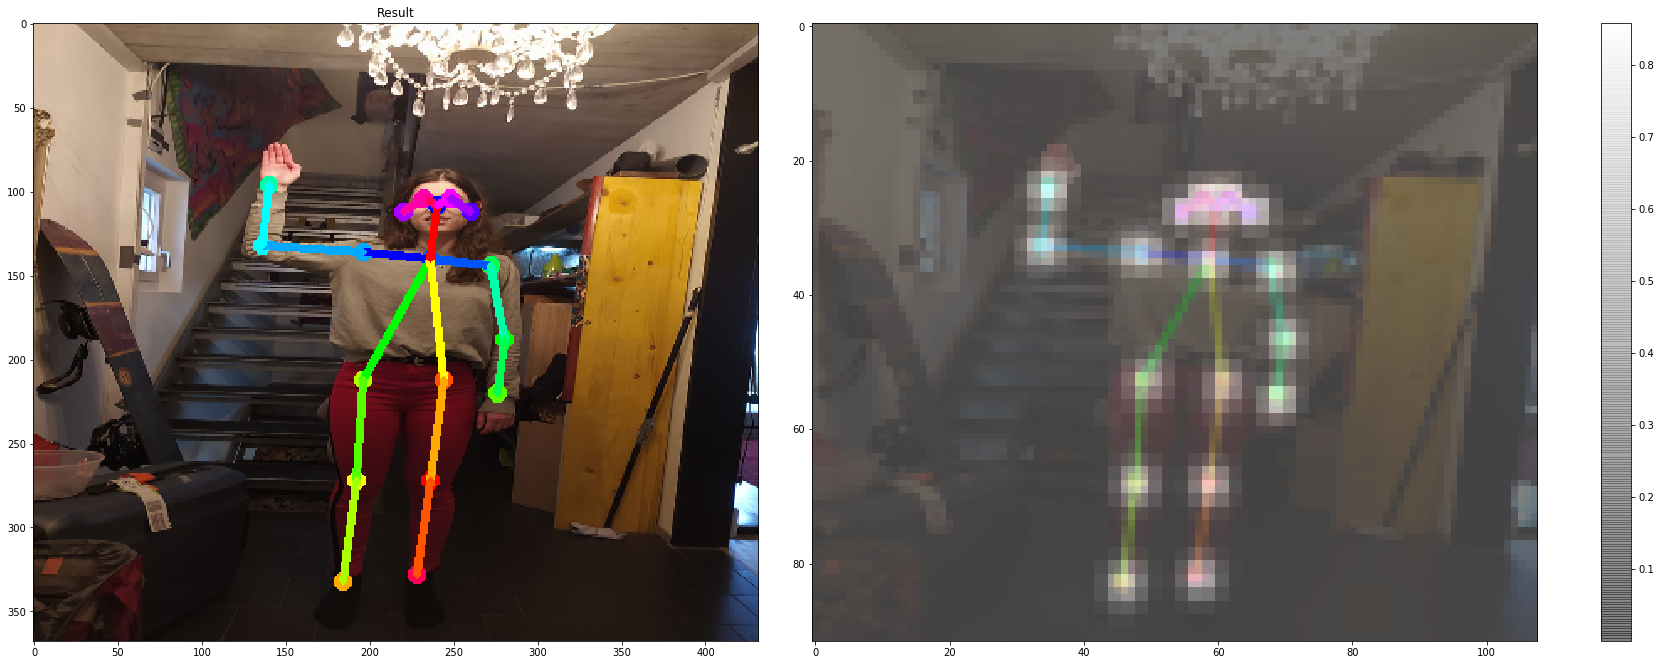

In [6]:
human_target = e_target.inference(image_target, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
plot_pose(image_target, human_target, e_target.heatMat)

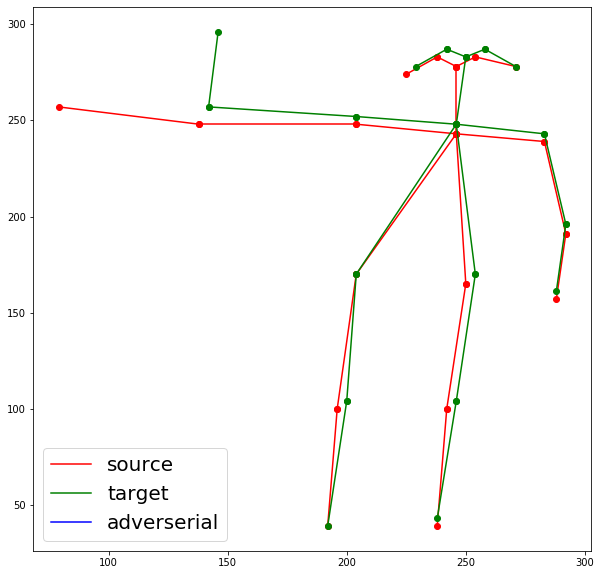

In [7]:
source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target'),
                   Line2D([0], [0], color='b', label='adverserial')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

In [8]:
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf, target_np_peaks = e_target.persistent_sess.run(
            [e_target.tensor_output, e_target.tensor_heatMat_up, e_target.tensor_pafMat_up, e_target.tensor_peaks],
            feed_dict={
                e_target.tensor_image: [image_target],
                e_target.upsample_size: upsample_size
            }
        )

source_np, source_np_heat, source_np_paf, source_np_peaks = e_source.persistent_sess.run(
            [e_source.tensor_output, e_source.tensor_heatMat_up, e_source.tensor_pafMat_up, e_source.tensor_peaks],
            feed_dict={
                e_source.tensor_image: [image_source],
                e_source.upsample_size: upsample_size
            }
        )


(1, 46, 54, 57)
(1, 92, 108, 19)
(1, 92, 108, 38)
(1, 92, 108, 19)


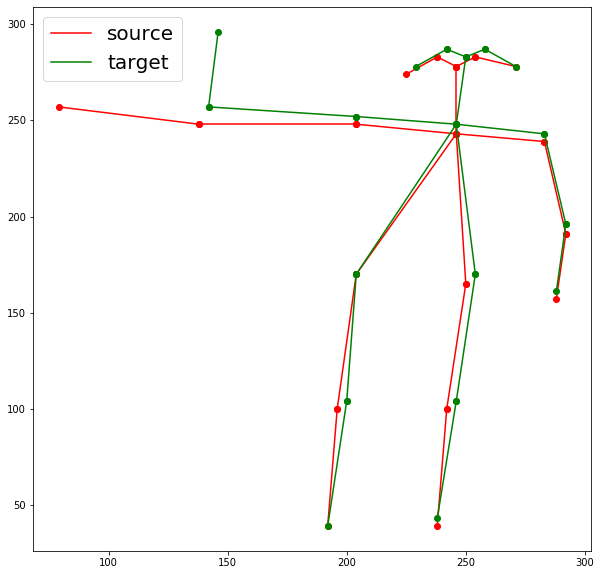

In [9]:
print(target_np.shape)
print(target_np_heat.shape)
print(target_np_paf.shape)
print(target_np_peaks.shape)

# for i in range(52):
#     print(np.sum(np.abs(target_np[:, :, :, i] - source_np[:, :, :, i])))


human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])


source_lines = get_humans_as_lines(human_source, 400, 450)
target_lines = get_humans_as_lines(human_target, 400, 450)


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

plot_human_lines(source_lines, ax, color='r', linestyle='-', label='source')
plot_human_lines(target_lines, ax, color='g', linestyle='-', label='target')

legend_elements = [Line2D([0], [0], color='r', label='source'),
                   Line2D([0], [0], color='g', label='target')]
ax.legend(handles=legend_elements, loc='best',  prop={'size': 20})

 40%|████      | 40/100 [03:27<06:03,  6.06s/it]/home/ax/miniconda3/envs/masterThesis/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 100/100 [09:48<00:00,  5.88s/it]


Min: 0
Max: 255
Avg: 64.82726323470209
Min: 0.0
Max: 255.0
Avg: 65.31367492675781
The total diff is 0.36632975921449634 and the part moved the most is the CocoPart.RWrist


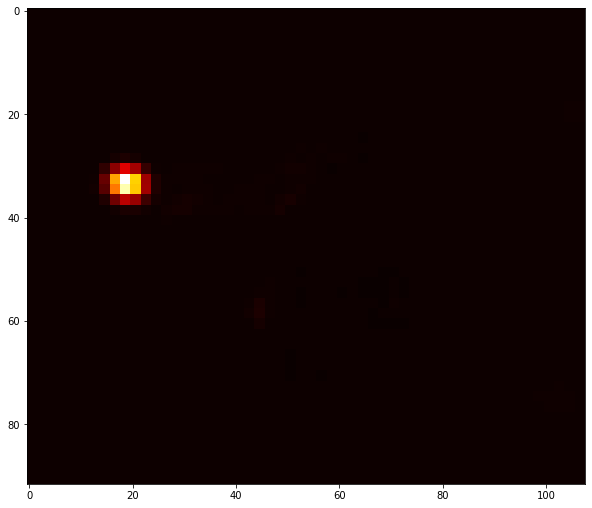

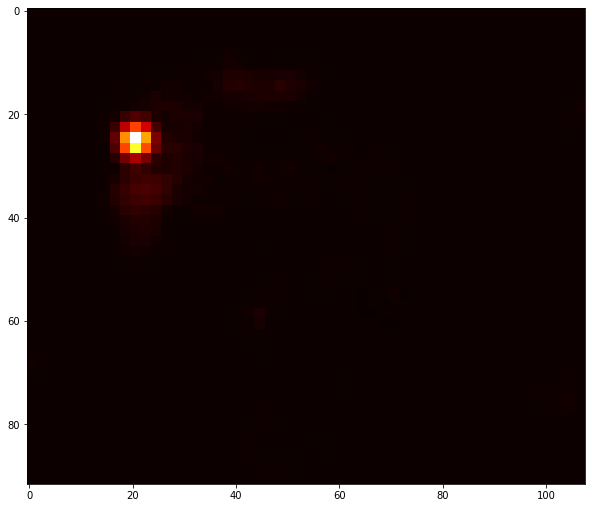

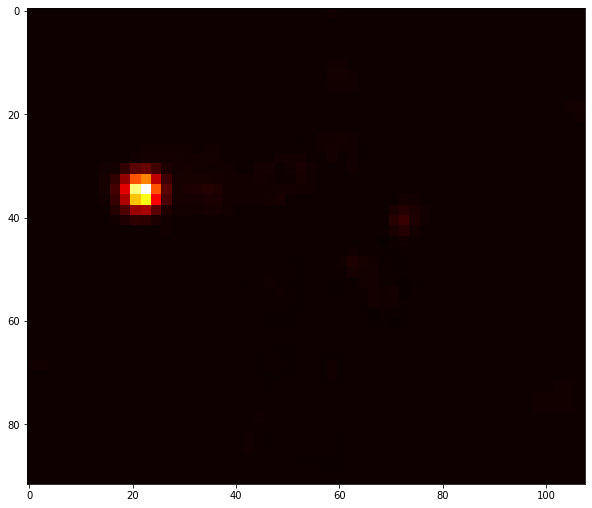

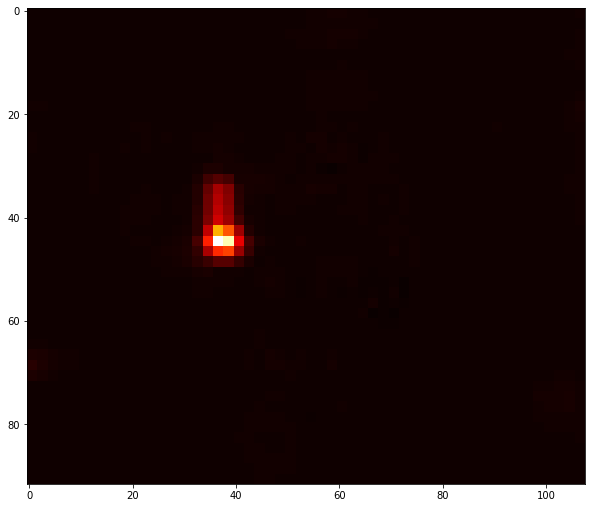

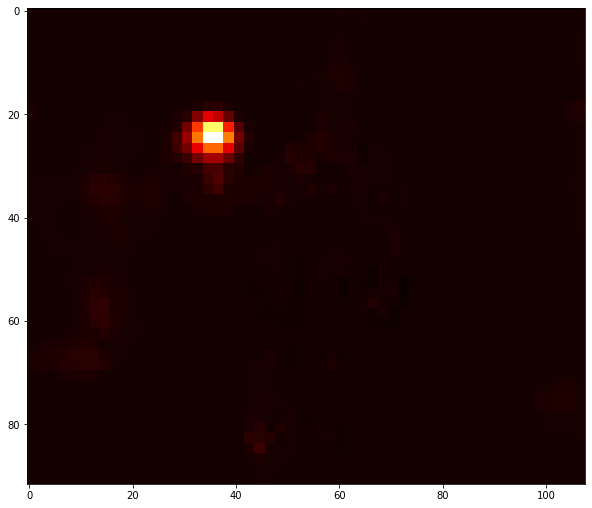

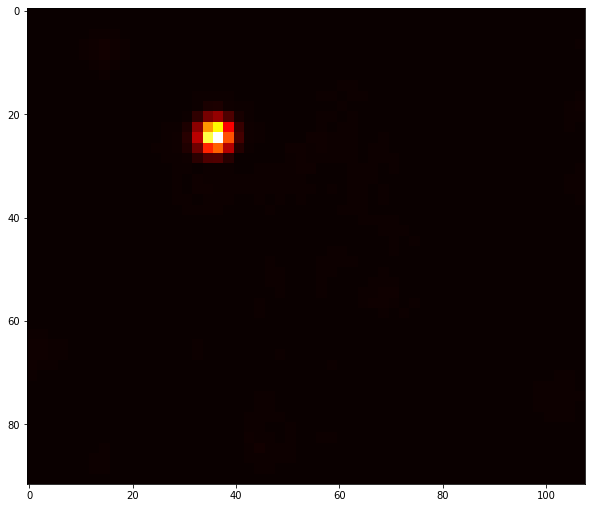

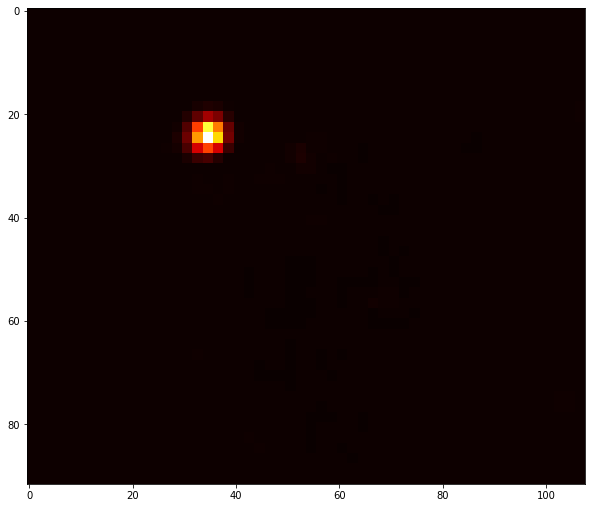

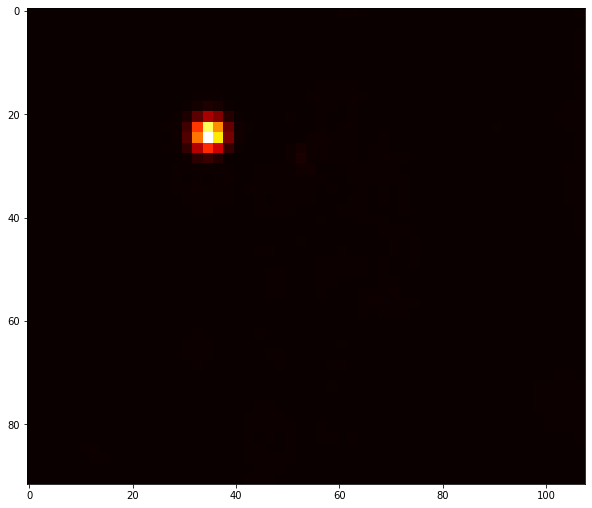

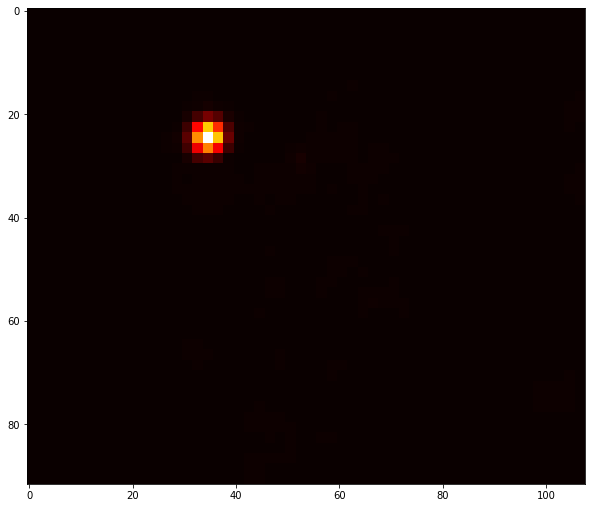

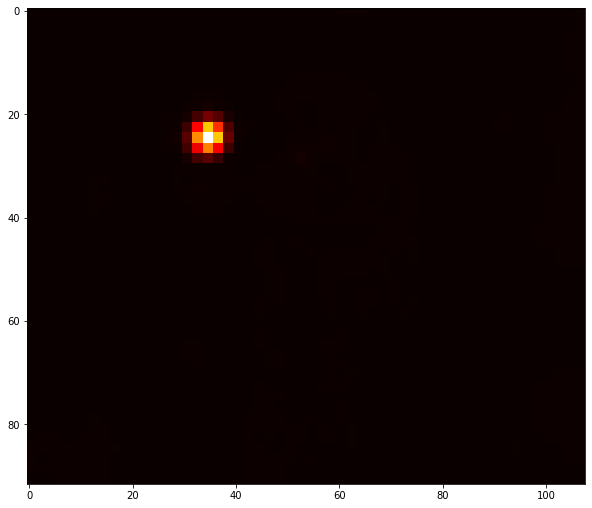

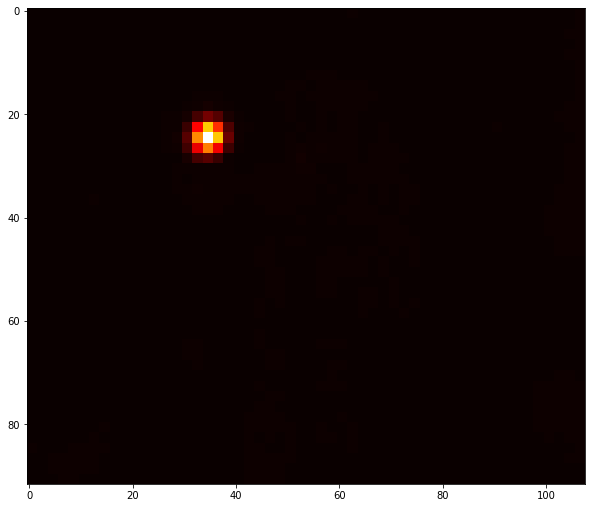

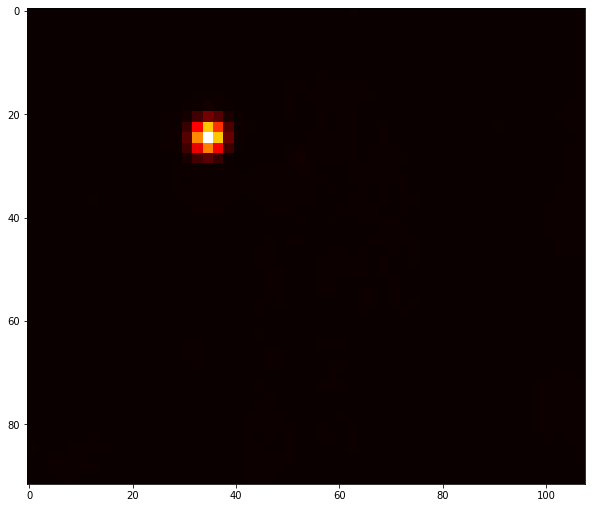

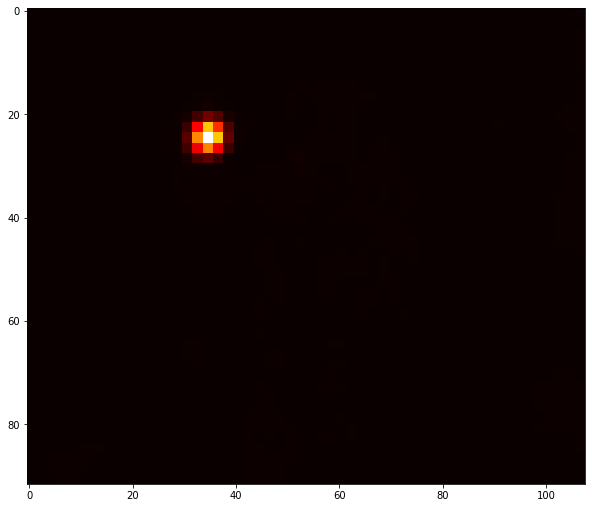

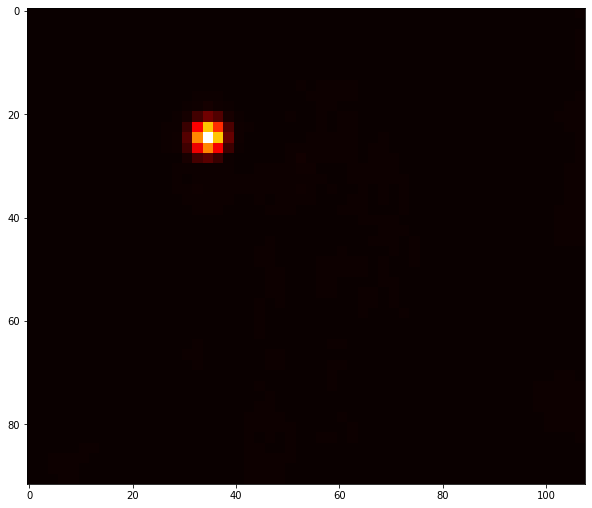

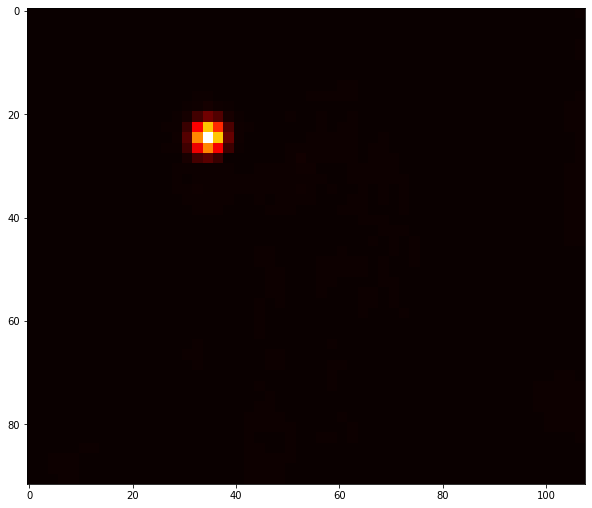

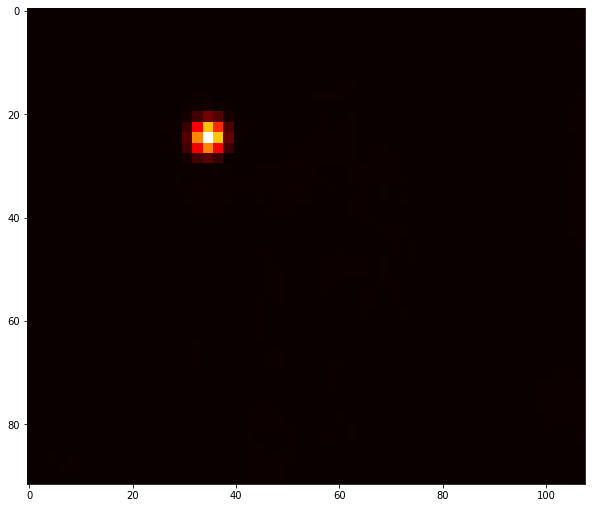

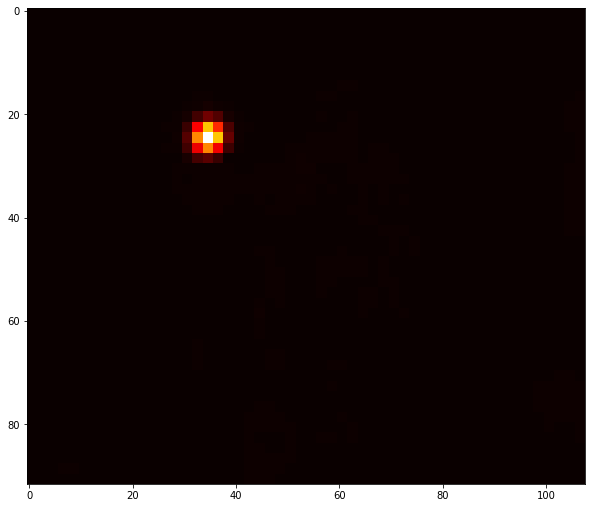

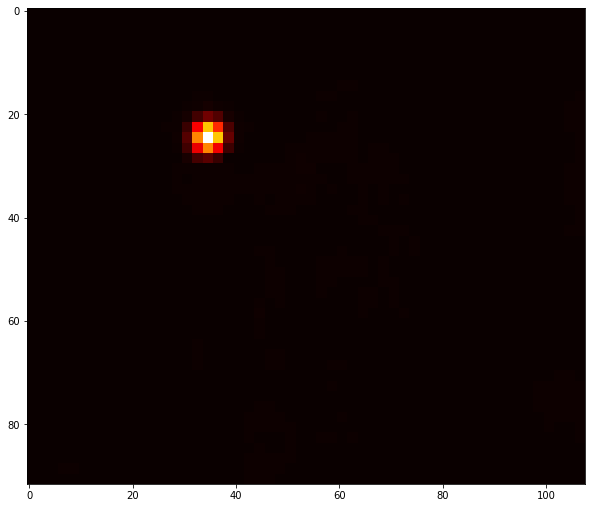

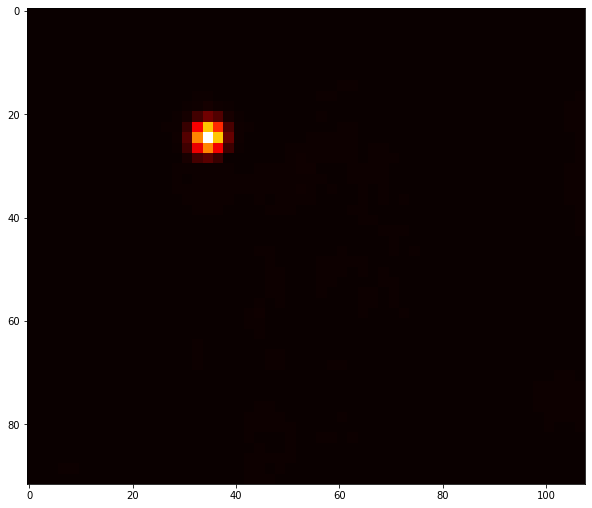

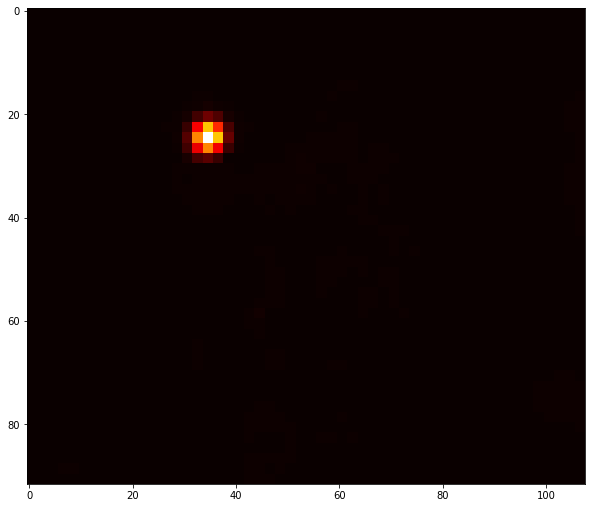

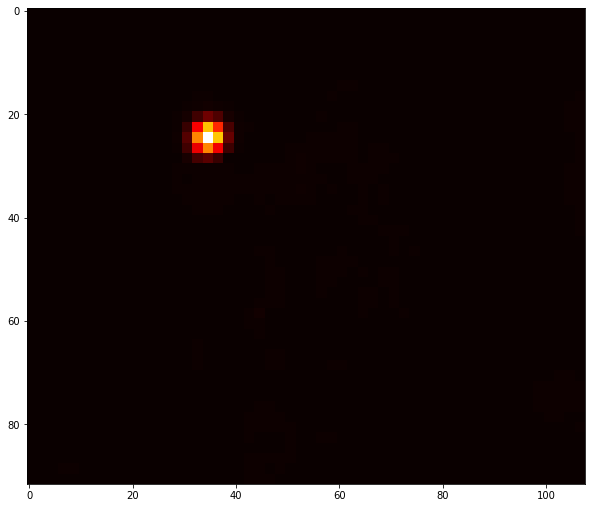

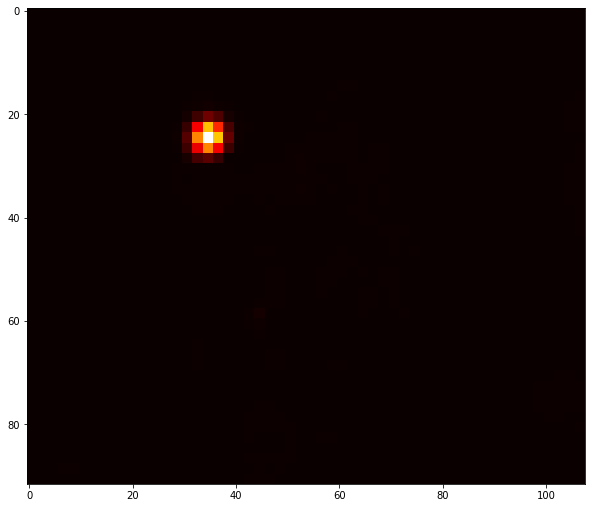

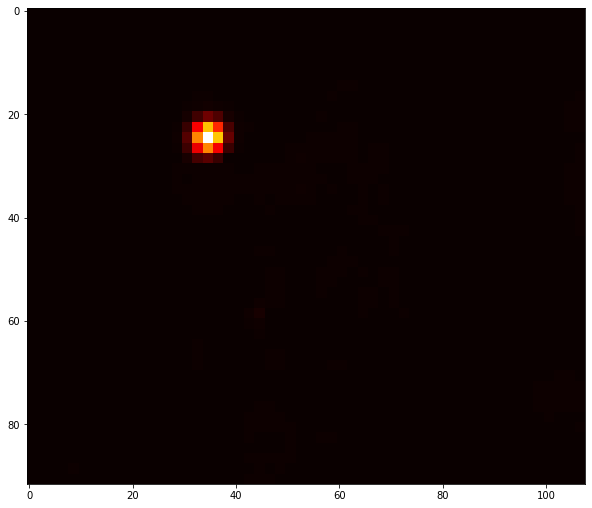

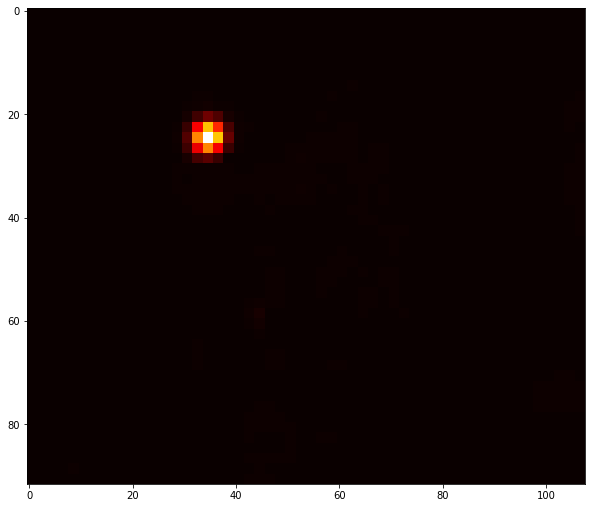

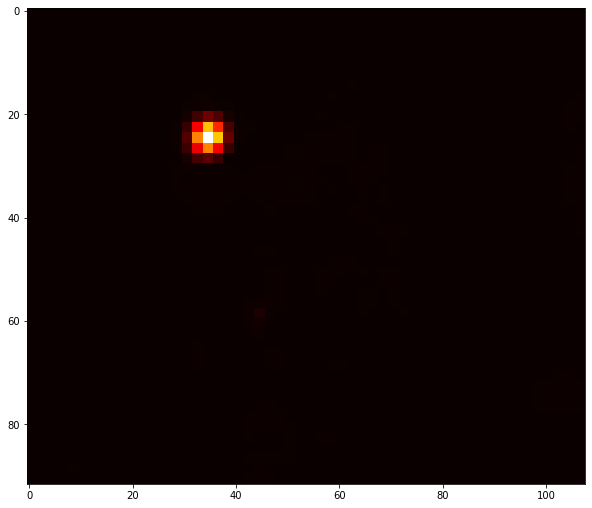

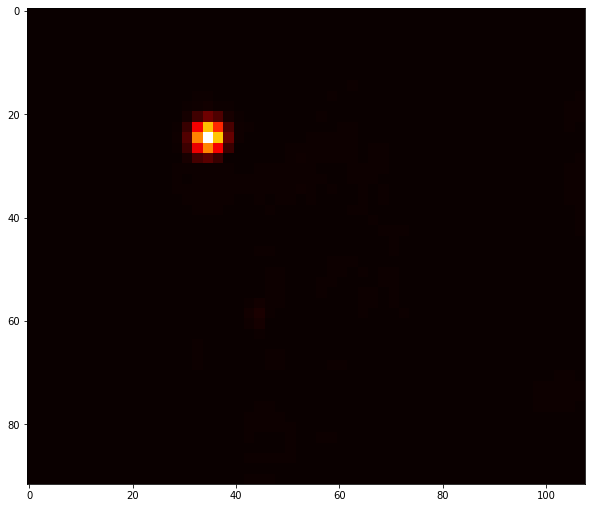

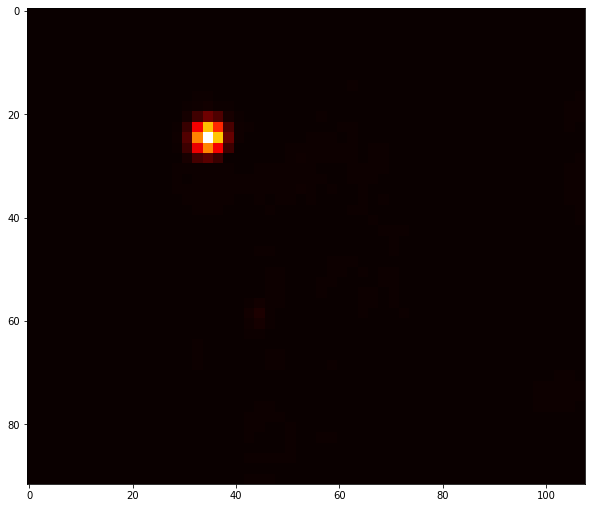

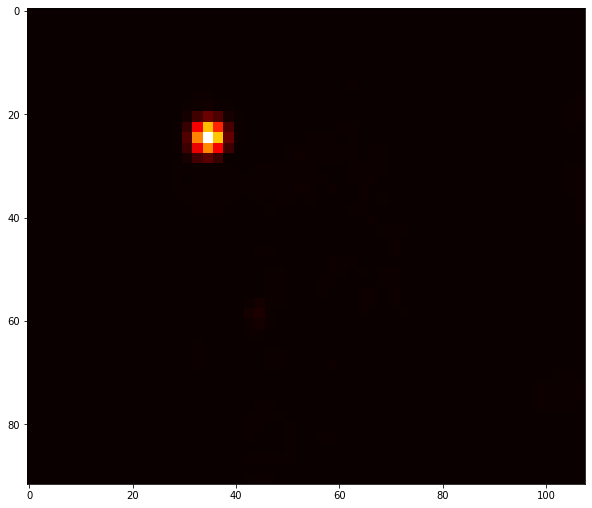

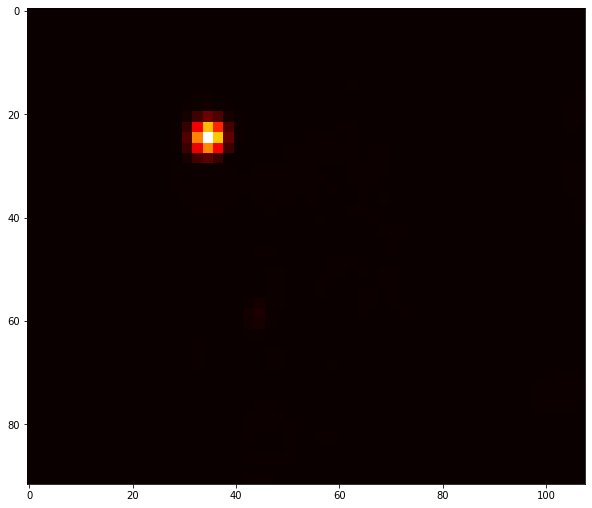

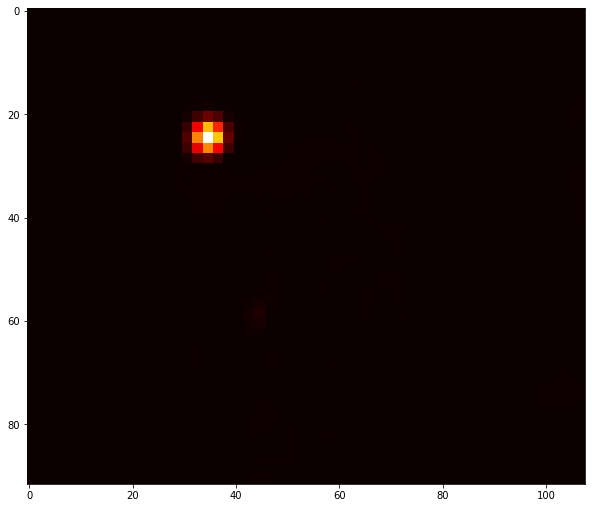

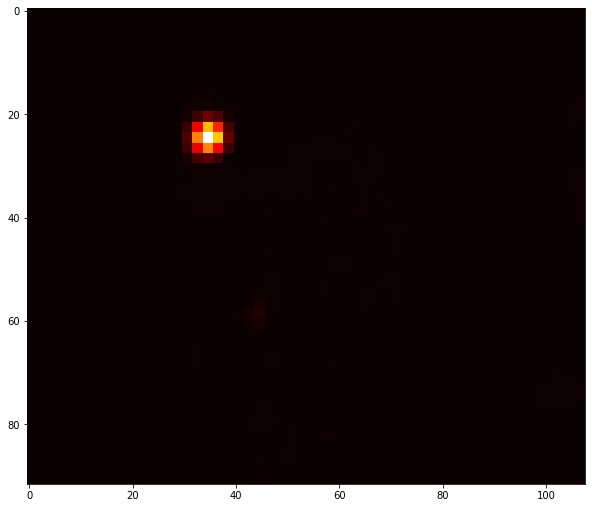

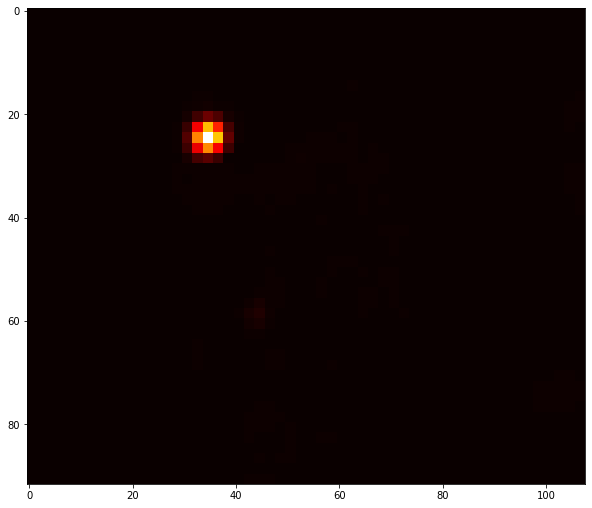

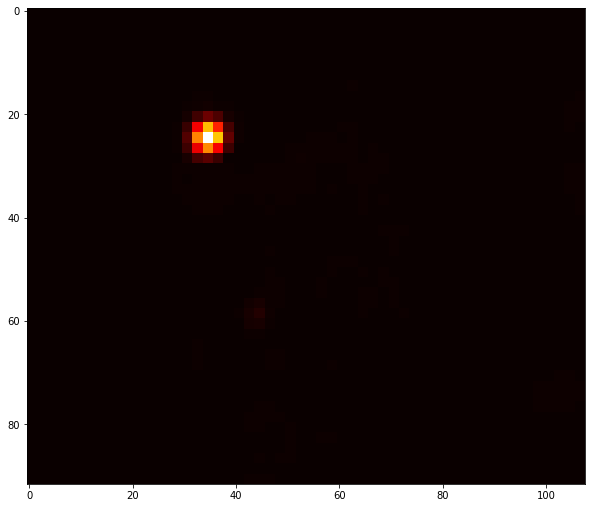

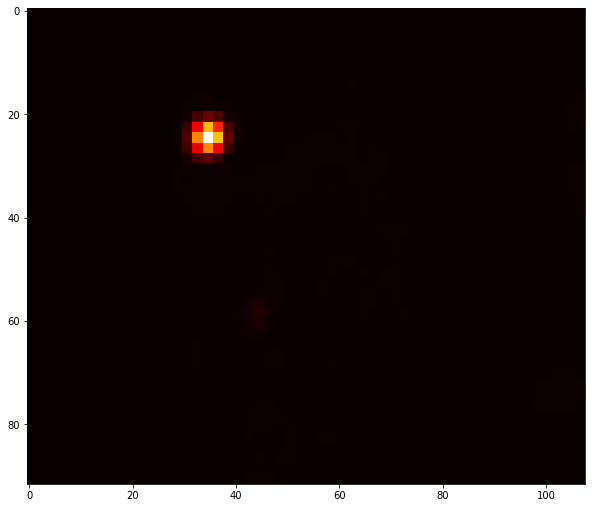

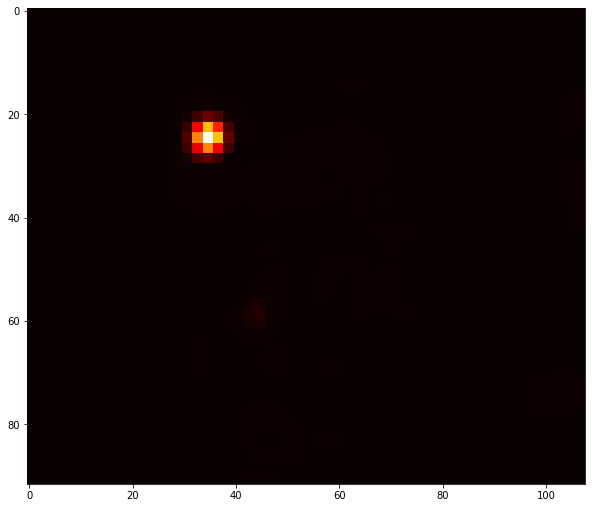

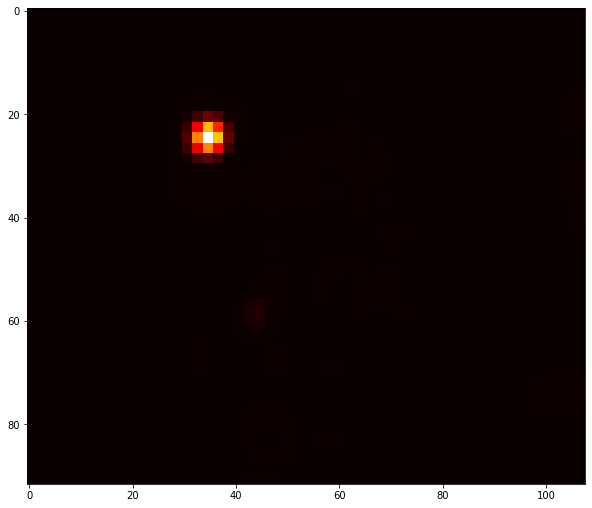

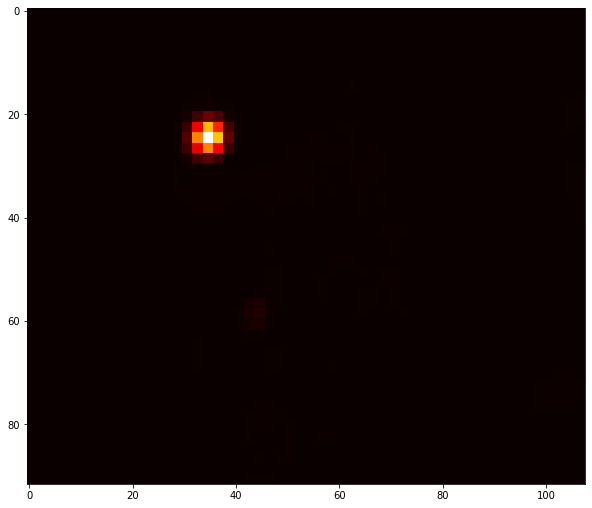

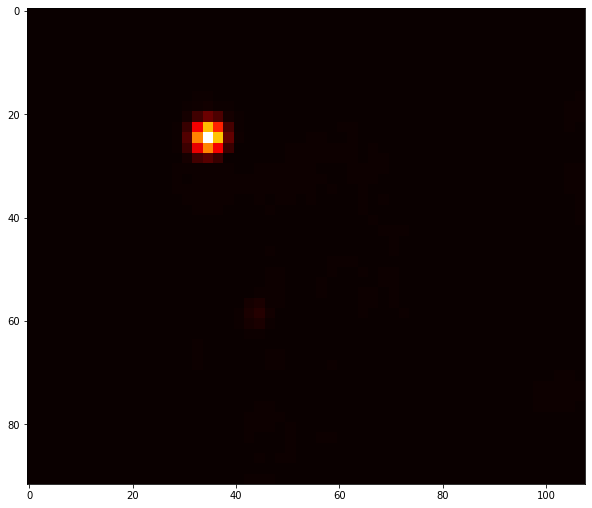

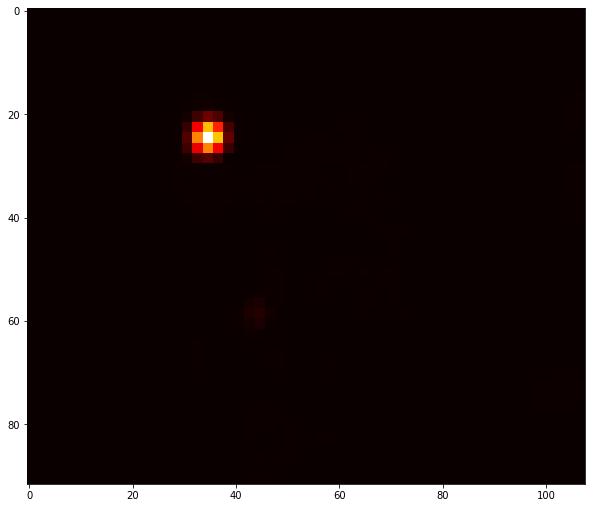

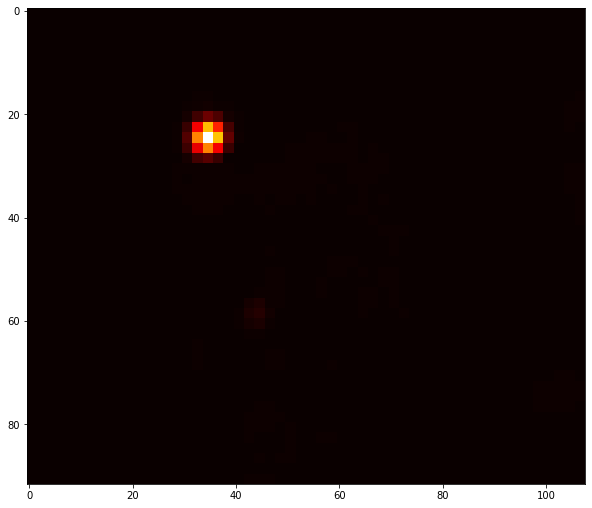

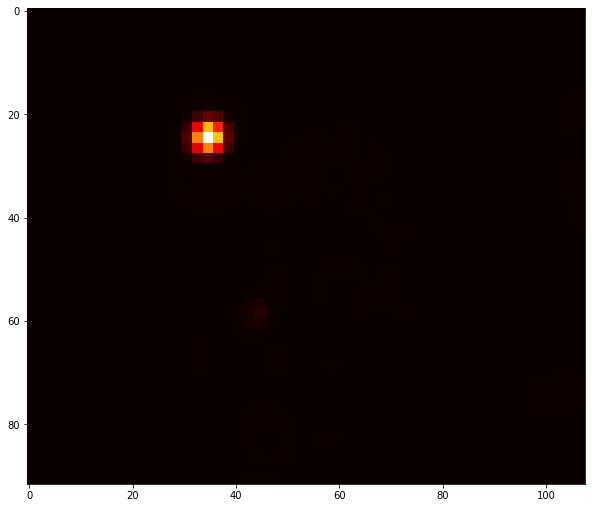

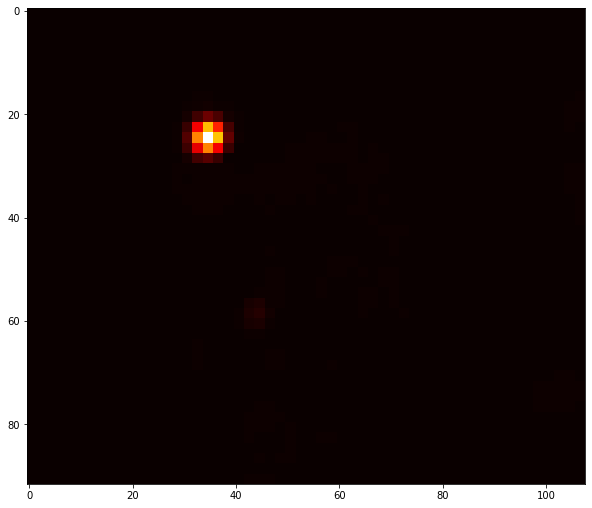

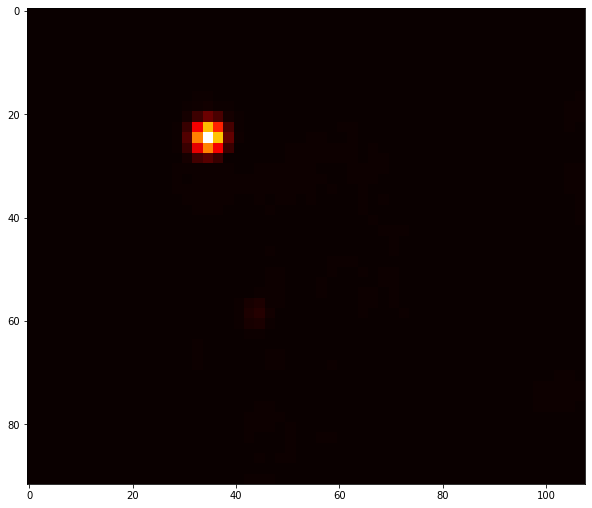

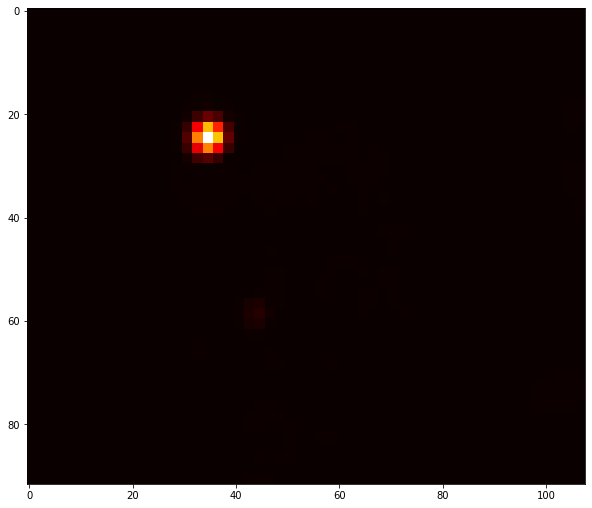

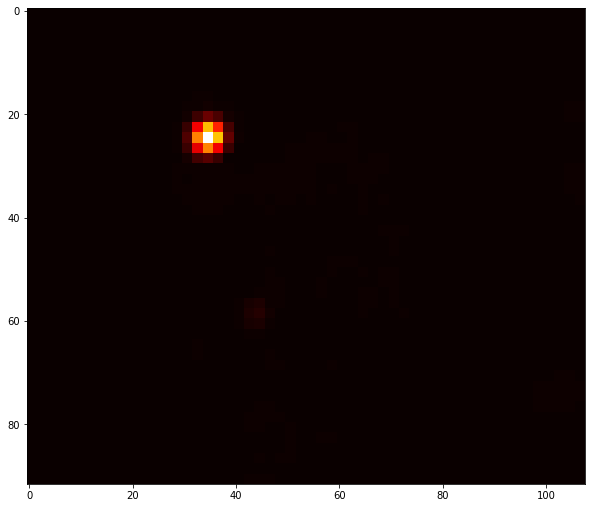

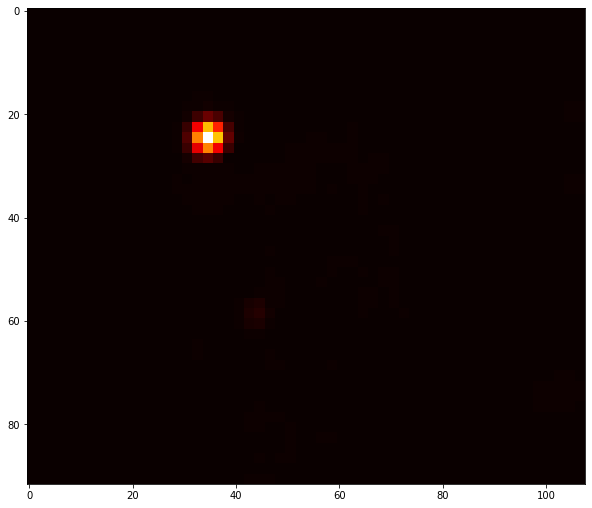

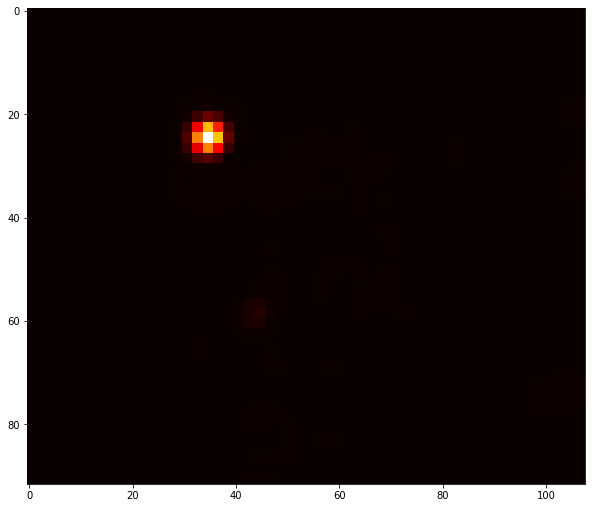

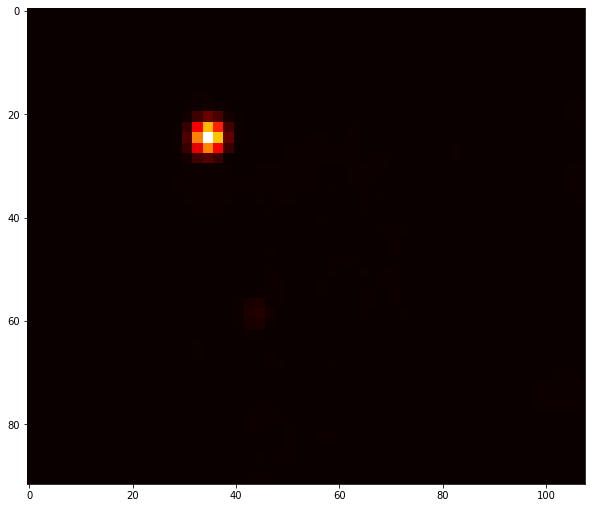

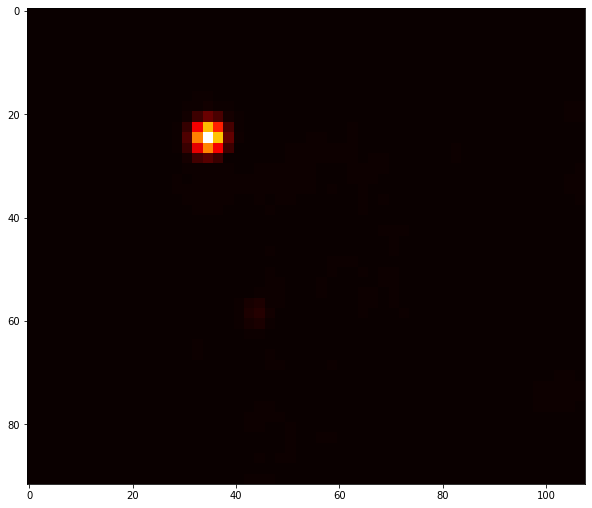

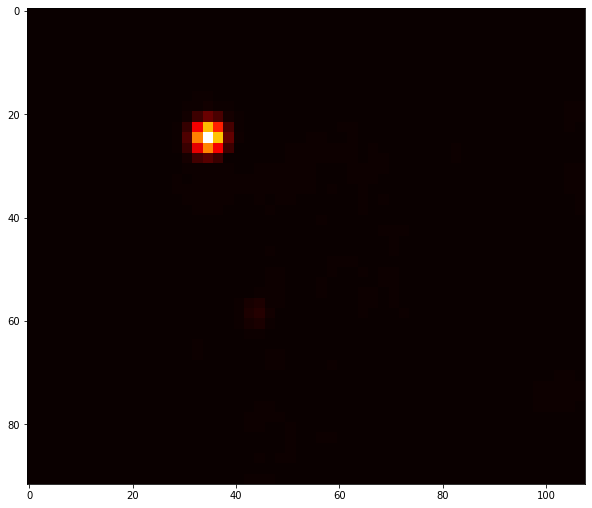

In [15]:
def gen_heat_plot(heatmap):
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.imshow(heatmap, cmap='hot')
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return buf


EPS = 5000
STEPS = 100
STAGE_INDEX = 6 # range from 2 to 6
ONLY_HEAT_MAP_AS_LOSS = False


if not "adv_image" in vars():
    adv_image = copy.deepcopy(image_source)
target_heat, grad_func, loss_func = [None, None, None]

human_source = PoseEstimator.estimate_paf(source_np_peaks[0], source_np_heat[0], source_np_paf[0])
human_target = PoseEstimator.estimate_paf(target_np_peaks[0], target_np_heat[0], target_np_paf[0])


if ONLY_HEAT_MAP_AS_LOSS:
    target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
    grad_func, loss_func = final_stage_heat_loss(e_source, target_heat)
else:
    
    target_heat = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 19))
    target_paf = tf.compat.v1.placeholder(tf.float32, shape=(None, None, None, 38))
    grad_func, loss_func = multi_stage_loss(e_source, target_heat, target_paf, STAGE_INDEX)

for i in tqdm(range(STEPS)):    
    # compute gradient
    gradient, gn_summ = e_source.persistent_sess.run(
                [grad_func, loss_func],
                feed_dict={
                    target_heat: target_np[:, :, :, CocoPart.RWrist.value] if ONLY_HEAT_MAP_AS_LOSS else target_np[:, :, :, :19],
                    target_paf: target_np[:, :, :, 19:],
                    e_source.tensor_image: [adv_image],
                    e_source.upsample_size: upsample_size
                }
            )
    summary_writer.add_summary(gn_summ, i)  
    if i % 2 == 0:
        human_adv = e_source.inference(adv_image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
        # Prepare the plot
        plot_buf = gen_heat_plot(e_source.heatMat[:,:, CocoPart.RWrist.value])

        # Convert PNG buffer to TF image
        tf_image = tf.image.decode_png(plot_buf.getvalue(), channels=4)

        # Add the batch dimension
        tf_image = tf.expand_dims(tf_image, 0)

        # Add image summary
        summary_op = tf.summary.image(f"heatmap_wrist_step{i}", tf_image)
        summary_img = e_source.persistent_sess.run(summary_op)
        # Write summary
    
        summary_writer.add_summary(summary_img)
        summary_writer.flush()
    
    
    ### ================= UPDATE STEP ================= ###
    #adv_image = adv_image - EPS * np.sign(gradient[0])
    scaled_gradient = (EPS * gradient[0])
    adv_image = adv_image - scaled_gradient
    adv_image = np.clip(adv_image, 0, 255)

summary_writer.flush()

human_adv = e_source.inference(adv_image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)
    
print_image_Stats(image_source)
print_image_Stats(adv_image)
total_diff, most_moved_part = compare_poses(human_source[0], human_adv[0])
print(f'The total diff is {total_diff} and the part moved the most is the {most_moved_part}')